# 📄 Storybook

- Here, we will combine text-to-image models and ChatGPT's story generation capabilities to ultimately produce both text and images for a picture book.

# Environment Setup and Model Preparation

In [ ]:
import openai
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Import DiffusionPipeline from diffusers to generate images
from diffusers import DiffusionPipeline


# Function to display the generated image
def display_image(image):
    plt.figure(figsize=(6, 9))
    plt.axis('off')
    plt.imshow(image)
    plt.show()


# Initialize Stable Diffusion model (using stabilityai/stable-diffusion-xl-base-1.0)
# Set model to use FP16 (faster and less VRAM usage) and load to CUDA device
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)
pipe.to("cuda")

# Set API information for accessing custom GPT model
apiKey = 'b0ae0438-7f12-4b6f-82b4-7211d6a7f5cd'
basicUrl = "https://genai.hkbu.edu.hk/general/rest"
modelName = "gpt-4-o-mini"
apiVersion = "2024-05-01-preview"

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Call the API

In [ ]:
def submit_full_response(messages):
    """
    Sends a list of messages to the API endpoint and returns the full JSON response.

    Args:
        messages (list): A list of dictionaries representing the chat messages (role and content).

    Returns:
        dict: The parsed JSON response containing the model's reply.

    Raises:
        Exception: If the HTTP request fails (status code not 200), an exception is raised with the error details.
    """
    url = basicUrl + "/deployments/" + modelName + "/chat/completions/?api-version=" + apiVersion
    headers = {'Content-Type': 'application/json', 'api-key': apiKey}
    payload = {'messages': messages, 'temperature': 0}  # Temperature is set to 0 for more deterministic outputs
    response = requests.post(url, json=payload, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error {response.status_code}: {response.text}")


# Setting Up the AI Function for Story Writing

In [ ]:
def generate_story(theme):
    """
    Generates a short, vivid story based on the given theme, suitable for a children's picture book.

    Args:
        theme (str): The main theme or topic of the story.

    Returns:
        str: The generated story text, cleaned and stripped of extra spaces.

    Notes:
        - The story will be around 250 to 350 words.
        - The language will be simple yet imaginative to inspire colorful illustrations.
        - The story will be naturally divided into 8 to 10 scenes.
    """
    messages = [
        {
            "role": "user",
            "content": (
                f"Write a short, vivid, and engaging story about '{theme}', "
                "suitable for a children's picture book. "
                "The story should be around 250 to 350 words, divided naturally into 8 to 10 scenes. "
                "Use simple but imaginative language to inspire colorful illustrations."
            )
        }
    ]
    response_data = submit_full_response(messages)
    return response_data['choices'][0]['message']['content'].strip()


Main function to generate a children's story, create prompts for each page,generate corresponding images using Stable Diffusion, and save/display the results.

Workflow:
1. Ask the user to input a theme for the story.
2. Generate a complete short story based on the given theme.
3. Split the story into multiple page excerpts and create detailed prompts for each excerpt.
4. Generate an illustration for each prompt using Stable Diffusion.
5. Save each generated image and display it.

Notes:
- The story is divided into 10 pages by default.
- Images are saved as "page_#.png" where # is the page number.
    

In [ ]:
def generate_page_prompts(story, num_pages):
    """
    Splits the story into several parts and generates detailed image prompts for each part.

    Args:
        story (str): The full story text.
        num_pages (int): The number of pages (scenes) to split the story into.

    Returns:
        tuple: Two lists -
            - page_contents (List[str]): The divided story excerpts for each page.
            - page_prompts (List[str]): The generated image prompts for each page.
    """
    # Split the story into sentences
    sentences = story.split('. ')
    page_prompts = []
    page_contents = []

    # Divide the story into num_pages parts
    for i in range(num_pages):
        start = i * len(sentences) // num_pages
        end = (i + 1) * len(sentences) // num_pages
        page_content = '. '.join(sentences[start:end]).strip()
        page_contents.append(page_content)

        # Prepare the system prompt for better prompt engineering
        system_prompt = {
            "role": "system",
            "content": (
                "You are an expert in creating highly detailed and vivid prompts for AI image generation models like Stable Diffusion. "
                "Your task is to create an imaginative, colorful, and detailed prompt based on a given story excerpt, "
                "suitable for a children's picture book illustration.\n\n"
                "Requirements:\n"
                "- Focus on the main characters, actions, setting, atmosphere, and emotions.\n"
                "- Include visual details such as background, time of day, lighting, environment, art style.\n"
                "- Style: Children's book illustration, colorful, soft lighting, dreamy.\n"
                "- Write the prompt in one fluent English sentence, no bullet points, no explanation.\n"
                "- Example style: 'A brave little fox crossing a sparkling river under the starry night, surrounded by glowing fireflies, in a soft watercolor children's book illustration, pastel colors, dreamy atmosphere.'"
            )
        }

        # Prepare the user prompt
        user_prompt = {"role": "user", "content": f"Story excerpt: {page_content}"}

        messages = [system_prompt, user_prompt]

        # Send the request and get the generated prompt
        response_data = submit_full_response(messages)
        page_prompt = response_data['choices'][0]['message']['content'].strip()

        page_prompts.append(page_prompt)

    return page_contents, page_prompts


Enter the theme for the story (e.g., fairy tale): friendship

Generated Full Story:

**Title: The Rainbow Bridge**

**Scene 1: The Lonely Cloud**  
In a bright blue sky, there lived a fluffy little cloud named Cumulus. Cumulus loved to float and play, but he felt lonely. “I wish I had a friend,” he sighed, watching the birds fly by.

**Scene 2: The Colorful Rainbow**  
One sunny day, after a gentle rain, a beautiful rainbow appeared. Cumulus gasped in delight! “Wow! Look at all those colors!” he exclaimed, his fluffy edges tingling with excitement.

**Scene 3: The Rainbow’s Secret**  
Curious, Cumulus floated closer. “Hello, Rainbow! Can you tell me your secret?” he asked. The rainbow shimmered and replied, “I’m made of friendship! Each color is a friend who helps me shine!”

**Scene 4: The Colorful Friends**  
Cumulus’s eyes sparkled. “Can I be your friend too?” he asked eagerly. The rainbow giggled, “Of course! But you must find the colors first!”

**Scene 5: The Red Adventure**  
Cu

  0%|          | 0/20 [00:00<?, ?it/s]


Cover image saved as page_0_cover.png

=== Page 1 ===
Story:
**Title: The Rainbow Bridge**

**Scene 1: The Lonely Cloud**  
In a bright blue sky, there lived a fluffy little cloud named Cumulus

Image Prompt:
A fluffy little cloud named Cumulus floating joyfully in a bright blue sky, surrounded by soft, white clouds and a radiant sun casting gentle rays, with a whimsical landscape of rolling green hills and colorful flowers below, all illustrated in a vibrant, dreamy children's book style with pastel colors and a cheerful atmosphere.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 1 saved as page_1.png


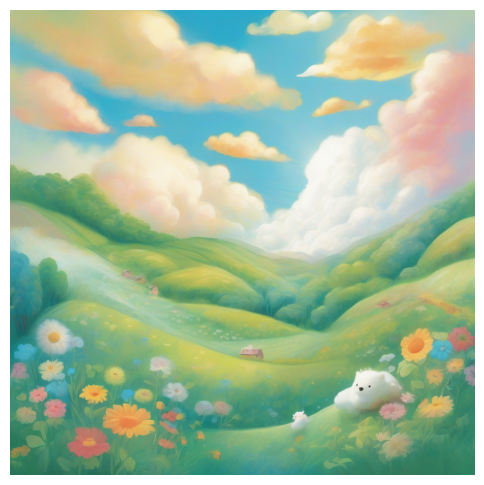


=== Page 2 ===
Story:
Cumulus loved to float and play, but he felt lonely. “I wish I had a friend,” he sighed, watching the birds fly by.

**Scene 2: The Colorful Rainbow**  
One sunny day, after a gentle rain, a beautiful rainbow appeared

Image Prompt:
A fluffy white cloud named Cumulus, with a soft, smiling face, gazes longingly at a vibrant rainbow arching across a bright blue sky, surrounded by playful birds soaring joyfully, as gentle sunlight filters through the scene, casting a warm, cheerful glow over the landscape in a whimsical children's book illustration, filled with pastel colors and a dreamy, uplifting atmosphere.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 2 saved as page_2.png


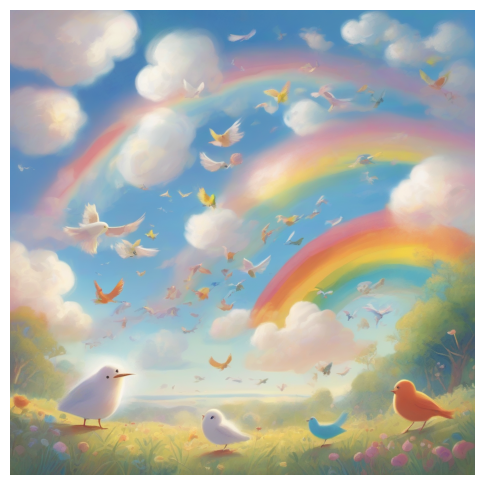

Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', cheerful colors and a dreamy, enchanting atmosphere.']
Token indices sequence length is longer than the specified maximum sequence length for this model (87 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', cheerful colors and a dreamy, enchanting atmosphere.']



=== Page 3 ===
Story:
Cumulus gasped in delight! “Wow! Look at all those colors!” he exclaimed, his fluffy edges tingling with excitement.

**Scene 3: The Rainbow’s Secret**  
Curious, Cumulus floated closer. “Hello, Rainbow! Can you tell me your secret?” he asked

Image Prompt:
A fluffy, white cloud named Cumulus, with soft, billowing edges, floats joyfully in a vibrant sky filled with a dazzling rainbow arching across the horizon, surrounded by fluffy cotton candy clouds, as the sun sets in a warm, golden glow, casting a magical light that dances on the colors of the rainbow, in a whimsical children's book illustration style, with bright, cheerful colors and a dreamy, enchanting atmosphere.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 3 saved as page_3.png


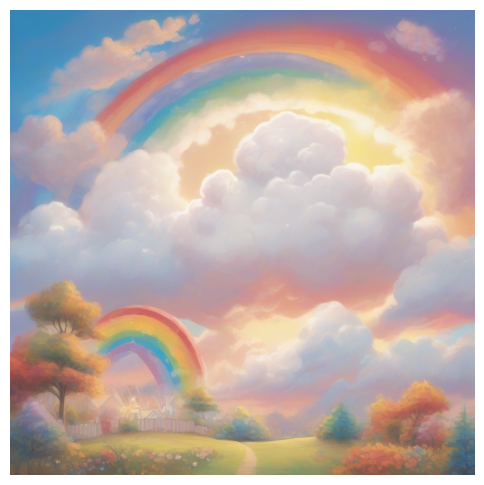


=== Page 4 ===
Story:
The rainbow shimmered and replied, “I’m made of friendship! Each color is a friend who helps me shine!”

**Scene 4: The Colorful Friends**  
Cumulus’s eyes sparkled. “Can I be your friend too?” he asked eagerly

Image Prompt:
A fluffy white cumulus cloud with sparkling eyes floating joyfully in a bright blue sky, reaching out towards a vibrant rainbow that arches gracefully above, each color radiating warmth and friendship, surrounded by soft, fluffy clouds and a few playful birds, in a whimsical children's book illustration style, filled with pastel colors and a dreamy, cheerful atmosphere.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 4 saved as page_4.png


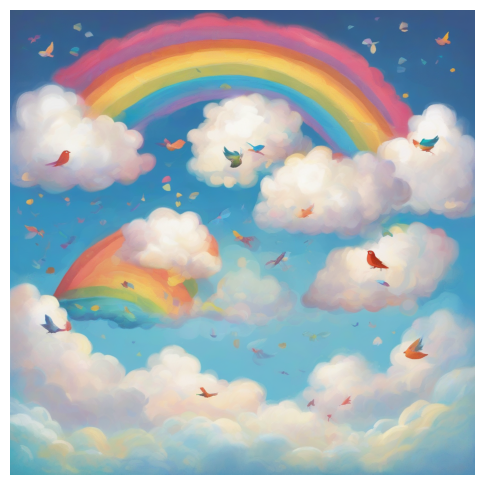


=== Page 5 ===
Story:
The rainbow giggled, “Of course! But you must find the colors first!”

**Scene 5: The Red Adventure**  
Cumulus zoomed down to the ground, where he found Ruby the red ladybug. “Will you be my friend?” he asked

Image Prompt:
A cheerful little cloud named Cumulus swooping down to a vibrant green meadow, where a bright red ladybug named Ruby is perched on a daisy, surrounded by colorful wildflowers and sparkling dewdrops, with a soft, pastel sky painted in shades of blue and pink, in a whimsical children's book illustration style, filled with warmth and a sense of friendship.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 5 saved as page_5.png


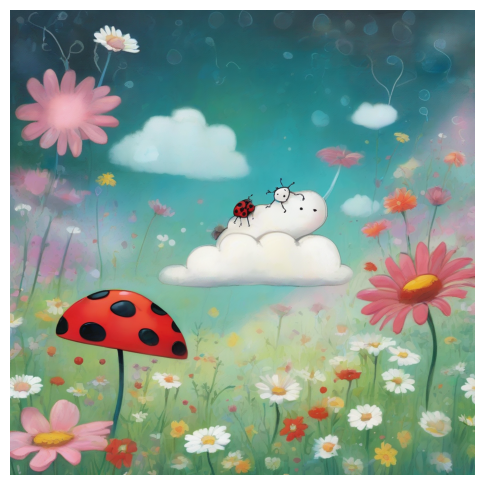


=== Page 6 ===
Story:
Ruby smiled, “Yes! Let’s play tag!” They laughed and danced in the sun.

**Scene 6: The Orange Encounter**  
Next, Cumulus met Oliver the orange fox. “Join us!” he called

Image Prompt:
A joyful scene of Ruby and Oliver the orange fox playing tag in a sun-drenched meadow filled with vibrant wildflowers, their laughter echoing through the air as they dance under a bright blue sky with fluffy white clouds, illustrated in a whimsical children's book style with soft, warm lighting and a dreamy, colorful atmosphere.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 6 saved as page_6.png


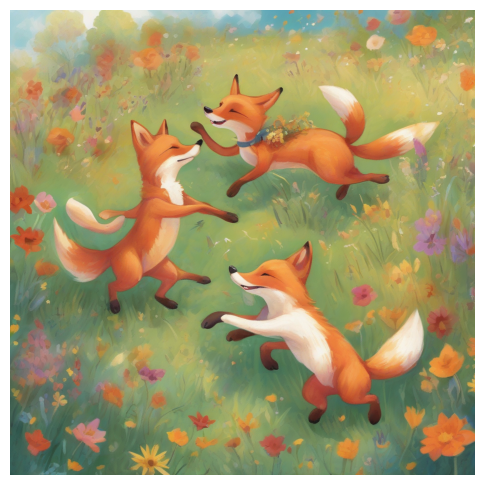


=== Page 7 ===
Story:
Oliver wagged his tail, “I’d love to!” Together, they played hide-and-seek among the tall grass.

**Scene 7: The Yellow Surprise**  
Then came Sunny the yellow butterfly. “Can I join your fun?” she fluttered

Image Prompt:
A joyful scene of Oliver, a playful puppy with a wagging tail, and his friend hiding among the tall, swaying green grass under a bright blue sky, as Sunny the vibrant yellow butterfly flutters in with a friendly smile, surrounded by colorful wildflowers and soft, dappled sunlight creating a warm, cheerful atmosphere in a whimsical children's book illustration style.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 7 saved as page_7.png


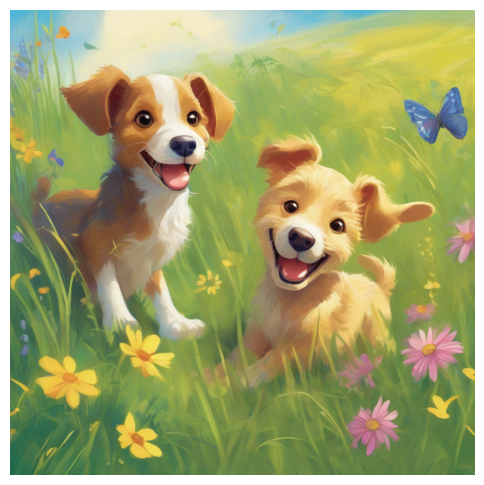


=== Page 8 ===
Story:
“Absolutely!” cheered Cumulus. They twirled and spun, creating a whirlwind of joy.

**Scene 8: The Friendship Grows**  
One by one, Cumulus gathered all the colors: Green, Blue, Indigo, and Violet

Image Prompt:
A joyful cloud named Cumulus twirling and spinning in a vibrant sky, surrounded by swirling ribbons of Green, Blue, Indigo, and Violet, as they create a dazzling whirlwind of colors against a soft, pastel sunset, in a whimsical children's book illustration with a dreamy atmosphere and gentle, glowing light.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 8 saved as page_8.png


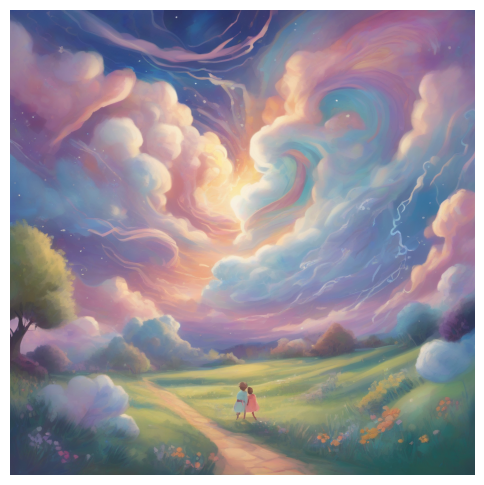


=== Page 9 ===
Story:
Each friend brought laughter and love, and soon, they formed a dazzling rainbow together.

**Scene 9: The Rainbow Bridge**  
Cumulus floated high, beaming with happiness. “Look at us!” he cheered

Image Prompt:
A joyful cloud named Cumulus, glowing with happiness, floats high above a vibrant landscape where a dazzling rainbow bridge arcs across the sky, surrounded by cheerful friends of various colors and shapes, all laughing and celebrating together in a whimsical children's book illustration, with soft pastel colors, warm sunlight filtering through fluffy clouds, and a dreamy, enchanting atmosphere.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 9 saved as page_9.png


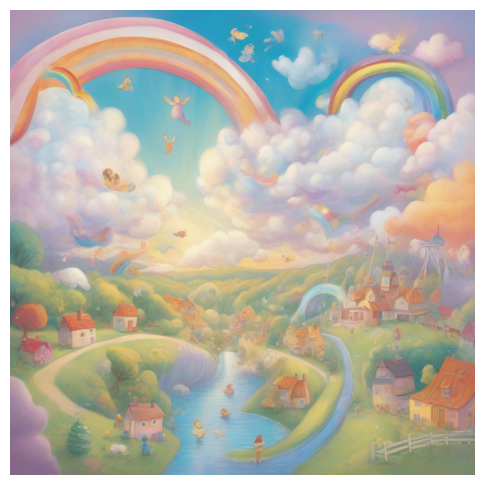

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['togetherness.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['togetherness.']



=== Page 10 ===
Story:
“We’re a rainbow of friendship!” The colors sparkled, creating a bridge of joy across the sky.

**Scene 10: Forever Friends**  
From that day on, Cumulus was never lonely again. He learned that friendship is the brightest color of all, and together, they painted the sky with laughter and love.

Image Prompt:
A fluffy, smiling cloud named Cumulus joyfully floats in a vibrant sky filled with swirling colors of a rainbow, as cheerful little friends—colorful birds, playful butterflies, and a friendly sun—dance around him, creating a magical bridge of joy, all illustrated in a soft, dreamy watercolor style with pastel hues and warm, glowing light that evokes a sense of happiness and togetherness.



  0%|          | 0/20 [00:00<?, ?it/s]

Image for Page 10 saved as page_10.png


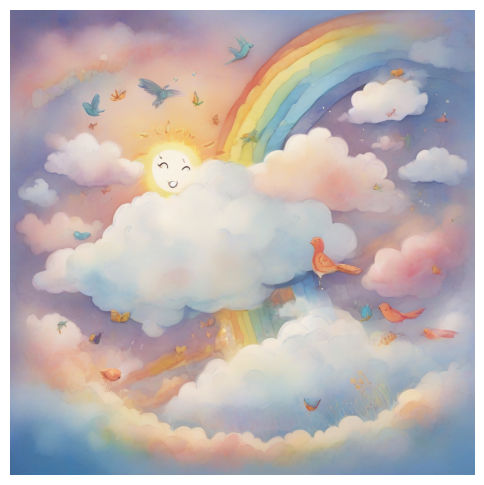

In [ ]:
def generate_cover_prompt(theme):
    """
    Generate a special prompt for the storybook cover illustration.
    The cover should be colorful, dreamy, and related to the theme.
    """
    cover_prompt = (
        f"A beautiful, colorful storybook cover illustration for a children's book about '{theme}'. "
        "Include imaginative elements, soft pastel colors, dreamy atmosphere, "
        "large whimsical title space, in a watercolor art style, cute and vibrant."
    )
    return cover_prompt

def main():
    """
    Main function to generate a storybook with text and illustrations.
    Includes a cover page, story pages, and saves images.
    """
    theme = input("Enter the theme for the story (e.g., fairy tale): ")

    # Generate the story
    story = generate_story(theme)
    print("\nGenerated Full Story:\n")
    print(story)

    num_pages = 10

    # Generate cover
    cover_prompt = generate_cover_prompt(theme)
    cover_image = pipe(cover_prompt, num_inference_steps=20).images[0]
    cover_image.save("page_0_cover.png")
    print("\nCover image saved as page_0_cover.png")

    # Generate story pages
    page_contents, page_prompts = generate_page_prompts(story, num_pages)

    for i, (content, prompt) in enumerate(zip(page_contents, page_prompts)):
        print(f"\n=== Page {i+1} ===")
        print(f"Story:\n{content}\n")
        print(f"Image Prompt:\n{prompt}\n")

        # Generate image for the page
        image = pipe(prompt, num_inference_steps=20).images[0]

        # Save the image
        image.save(f"page_{i+1}.png")
        print(f"Image for Page {i+1} saved as page_{i+1}.png")

        # Display the image
        display_image(image)

if __name__ == "__main__":
    main()
